In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load ConvNeXt Small with pretrained weights
model = convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)
model.eval()  # Set to evaluation mode

print("ConvNeXt Small loaded successfully!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

ConvNeXt Small loaded successfully!
Number of parameters: 50,223,688


In [3]:
# Inspect model architecture
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [4]:
# Load ImageNet class labels
# We need to reload the model to ensure we have the full 1000-class model
model_for_classification = convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)
model_for_classification.eval()

# Try to download ImageNet class labels with multiple fallback options
import urllib.request
import urllib.parse

imagenet_classes = None

# Try different URLs with proper headers
urls_to_try = [
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsid_to_human.txt",
]

for url in urls_to_try:
    try:
        req = urllib.request.Request(url)
        req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
        with urllib.request.urlopen(req, timeout=10) as response:
            content = response.read().decode('utf-8')
            # Handle different formats
            if url.endswith('imagenet_classes.txt'):
                imagenet_classes = [line.strip() for line in content.strip().split('\n') if line.strip()]
            else:
                # Parse dictionary format: '0': 'tench, Tinca tinca',
                lines = [line.strip() for line in content.strip().split('\n') if line.strip()]
                imagenet_classes = []
                for line in lines:
                    if "': '" in line or '": "' in line:
                        parts = line.split("'") if "'" in line else line.split('"')
                        if len(parts) >= 4:
                            imagenet_classes.append(parts[3].split(',')[0])  # Take first part before comma
                # Sort by index if we got them
                if imagenet_classes:
                    # Reorder if needed - try to maintain ImageNet order
                    pass
        
        if imagenet_classes and len(imagenet_classes) == 1000:
            print(f"Successfully downloaded ImageNet classes from {url}")
            break
    except Exception as e:
        print(f"Failed to download from {url}: {e}")
        continue

# Fallback: Try loading from local file if download failed
if imagenet_classes is None or len(imagenet_classes) != 1000:
    try:
        with open("imagenet_classes.txt", "r") as f:
            imagenet_classes = [line.strip() for line in f.readlines() if line.strip()]
        print(f"Loaded {len(imagenet_classes)} ImageNet classes from local file")
    except FileNotFoundError:
        print("Local file not found.")
    except Exception as e:
        print(f"Error reading local file: {e}")

# Final check
if imagenet_classes is None or len(imagenet_classes) != 1000:
    raise ValueError(
        f"Could not load ImageNet classes (got {len(imagenet_classes) if imagenet_classes else 0} classes).\n"
        "Please manually download imagenet_classes.txt from:\n"
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt\n"
        "and place it in the current directory."
    )

print(f"Loaded {len(imagenet_classes)} ImageNet classes")
print(f"Example classes: {imagenet_classes[:5]}")

Successfully downloaded ImageNet classes from https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Loaded 1000 ImageNet classes
Example classes: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


In [5]:
# Define image preprocessing pipeline for ConvNeXt
# ConvNeXt expects normalized images in [0, 1] range
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Preprocessing pipeline ready!")

Preprocessing pipeline ready!


In [6]:
# Helper function to classify an image and return top predictions
def classify_image(image_path_or_url, model, preprocess_fn, class_names, top_k=5):
    """
    Classify an image and return top predictions
    
    Args:
        image_path_or_url: Path to local image file or URL
        model: The trained model
        preprocess_fn: Preprocessing function
        class_names: List of class names
        top_k: Number of top predictions to return
    """
    from PIL import Image
    
    # Load image
    if image_path_or_url.startswith(('http://', 'https://')):
        import urllib.request
        import os
        # Use proper headers to avoid 403 errors
        req = urllib.request.Request(image_path_or_url)
        req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')
        req.add_header('Referer', 'https://www.google.com/')
        
        # Create unique temp filename based on URL to avoid conflicts
        import hashlib
        url_hash = hashlib.md5(image_path_or_url.encode()).hexdigest()[:8]
        temp_filename = f"temp_image_{url_hash}.jpg"
        
        with urllib.request.urlopen(req, timeout=10) as response:
            with open(temp_filename, 'wb') as out_file:
                out_file.write(response.read())
        
        image = Image.open(temp_filename).convert('RGB')
        # Optionally clean up temp file (commented out in case user wants to keep it)
        # os.remove(temp_filename)
    else:
        image = Image.open(image_path_or_url).convert('RGB')
    
    # Preprocess
    input_tensor = preprocess_fn(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    
    # Predict
    with torch.no_grad():
        output = model(input_batch)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # Get top predictions
    top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Format results
    results = []
    for i in range(top_k):
        idx = top_indices[i].item()
        prob = top_probs[i].item()
        class_name = class_names[idx]
        results.append((class_name, prob))
    
    return image, results

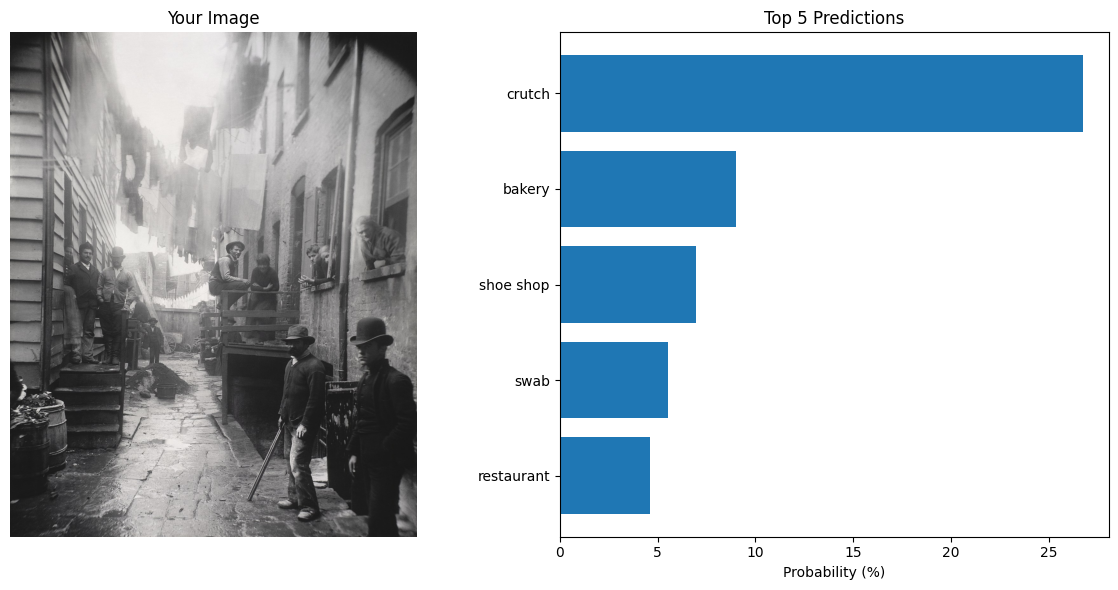


Top 5 Predictions:
1. crutch: 26.72%
2. bakery: 9.01%
3. shoe shop: 6.97%
4. swab: 5.54%
5. restaurant: 4.63%


In [7]:
# Example 3: Classify a local image file
# To use this, place an image file in the current directory and update the path below
# Uncomment and modify the path to use your own image:

local_image_path = "/Users/martindokholyan/Desktop/Important/Bandits_Roost,_59_and_a_half_Mulberry_Street.jpg"  # Change this to your image path

original_image, predictions = classify_image(
    local_image_path,
    model_for_classification,
    preprocess,
    imagenet_classes,
    top_k=5
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title('Your Image')

plt.subplot(1, 2, 2)
classes = [pred[0].split(',')[0] for pred in predictions]
probs = [pred[1] * 100 for pred in predictions]
plt.barh(range(len(classes)), probs)
plt.yticks(range(len(classes)), classes)
plt.xlabel('Probability (%)')
plt.title('Top 5 Predictions')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 Predictions:")
for i, (class_name, prob) in enumerate(predictions, 1):
    print(f"{i}. {class_name}: {prob*100:.2f}%")


# Class Activation Maps (Grad-CAM)

In [11]:
def generate_gradcam(image_path_or_url, model, preprocess_fn, class_names, top_k=3):
    """
    Generate Grad-CAM visualizations for the top predictions
    Shows which regions of the image are most important for each class
    """
    from PIL import Image
    import torch.nn.functional as F
    from scipy import ndimage
    import numpy as np
    
    # Try to import cv2, fallback to manual colormap if not available
    try:
        import cv2
        has_cv2 = True
    except ImportError:
        has_cv2 = False
        print("OpenCV not found. Using matplotlib colormap instead.")
    
    # Load and preprocess image
    if image_path_or_url.startswith(('http://', 'https://')):
        import urllib.request
        req = urllib.request.Request(image_path_or_url)
        req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
        req.add_header('Referer', 'https://www.google.com/')
        import hashlib
        url_hash = hashlib.md5(image_path_or_url.encode()).hexdigest()[:8]
        temp_filename = f"temp_image_{url_hash}.jpg"
        with urllib.request.urlopen(req, timeout=10) as response:
            with open(temp_filename, 'wb') as out_file:
                out_file.write(response.read())
        original_image = Image.open(temp_filename).convert('RGB')
    else:
        original_image = Image.open(image_path_or_url).convert('RGB')
    
    # Store original size for later resizing
    original_size = original_image.size
    
    # Preprocess for model - do initial forward pass without gradients
    input_tensor = preprocess_fn(original_image)
    input_batch_no_grad = input_tensor.unsqueeze(0)
    
    # Convert image to numpy for visualization
    img_array = np.array(original_image)
    
    fig, axes = plt.subplots(1, top_k + 1, figsize=(5 * (top_k + 1), 5))
    
    # Show original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    
    # Get initial predictions to know which classes to visualize (no gradients)
    with torch.no_grad():
        output = model(input_batch_no_grad)
        probabilities = F.softmax(output[0], dim=0)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Generate Grad-CAM for each top prediction
    for idx in range(top_k):
        class_idx = top_indices[idx].item()
        class_name = class_names[class_idx]
        prob = top_probs[idx].item()
        
        # Create fresh input with gradients for this class
        input_batch = input_tensor.unsqueeze(0).requires_grad_(True)
        
        # Zero all gradients
        model.zero_grad()
        
        # Forward pass - get features
        features = model.features(input_batch)
        features.retain_grad()  # Keep gradients for features
        
        # Continue forward pass (rest of model)
        # Note: classifier expects 4D input (B, C, H, W), it does the flattening internally
        pooled = model.avgpool(features)
        
        # Pass pooled features (4D) directly to classifier
        # The classifier contains: LayerNorm2d -> Flatten -> Linear
        output = model.classifier(pooled)
        
        # Get output for this specific class
        class_output = output[0, class_idx]
        
        # Backward pass - compute gradients
        class_output.backward()
        
        # Get gradients from features.grad (should be 4D: B, C, H, W)
        if features.grad is not None:
            gradients_np = features.grad[0].cpu().detach().numpy()  # (C, H, W)
        else:
            print(f"Warning: Could not get gradients for {class_name}, using uniform weights")
            # Create uniform gradients matching feature dimensions
            features_np = features[0].cpu().detach().numpy()
            gradients_np = np.ones_like(features_np)
        
        # Get feature activations (4D: B, C, H, W)
        features_np = features[0].cpu().detach().numpy()  # (C, H, W)
        
        # Ensure gradients and features are 3D: (C, H, W)
        # They should already be 3D from indexing [0], but check anyway
        if len(gradients_np.shape) == 4:
            gradients_np = gradients_np[0]  # Remove batch dimension: (C, H, W)
        elif len(gradients_np.shape) != 3:
            print(f"Warning: Unexpected gradient shape {gradients_np.shape} for {class_name}, skipping")
            continue
            
        if len(features_np.shape) == 4:
            features_np = features_np[0]  # Remove batch dimension: (C, H, W)
        elif len(features_np.shape) != 3:
            print(f"Warning: Unexpected feature shape {features_np.shape} for {class_name}, skipping")
            continue
        
        # Calculate weights (global average pooling of gradients)
        # gradients_np should now be (C, H, W)
        if len(gradients_np.shape) == 3 and len(features_np.shape) == 3:
            weights = np.mean(gradients_np, axis=(1, 2))  # Average over spatial dims: (C,)
        else:
            # Fallback: use uniform weights
            weights = np.ones(features_np.shape[0])
        
        # Ensure weights match feature channels
        if len(weights) != features_np.shape[0]:
            # If mismatch, use mean or pad/truncate
            if len(weights) < features_np.shape[0]:
                weights = np.pad(weights, (0, features_np.shape[0] - len(weights)), mode='constant', constant_values=weights.mean())
            else:
                weights = weights[:features_np.shape[0]]
        
        # Generate CAM (weighted sum of feature maps)
        # Both should be (C, H, W) now
        cam = np.zeros(features_np.shape[1:], dtype=np.float32)  # (H, W)
        for i, w in enumerate(weights):
            if i < features_np.shape[0]:
                cam += w * features_np[i, :, :]
        
        # Apply ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # Resize CAM to original image size
        if has_cv2:
            cam_resized = cv2.resize(cam, original_size)
            # Create heatmap using OpenCV
            cam_uint8 = (cam_resized * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        else:
            # Use scipy for resizing and matplotlib for colormap
            cam_resized = ndimage.zoom(cam, (original_size[1]/cam.shape[0], original_size[0]/cam.shape[1]), order=1)
            # Apply colormap using matplotlib
            import matplotlib.cm as cm
            cam_normalized = (cam_resized * 255).astype(np.uint8)
            heatmap = cm.jet(cam_normalized)[:, :, :3]  # Remove alpha channel
            heatmap = (heatmap * 255).astype(np.uint8)
        
        # Overlay on original image
        overlay = (0.4 * img_array + 0.6 * heatmap).astype(np.uint8)
        
        # Display
        axes[idx + 1].imshow(overlay)
        axes[idx + 1].set_title(f'{class_name}\\n{prob*100:.1f}%', fontsize=11)
        axes[idx + 1].axis('off')
    
    plt.tight_layout()
    return fig

print("Grad-CAM visualization function ready!")
print("Use: generate_gradcam(image_path, model_for_classification, preprocess, imagenet_classes)")

Grad-CAM visualization function ready!
Use: generate_gradcam(image_path, model_for_classification, preprocess, imagenet_classes)


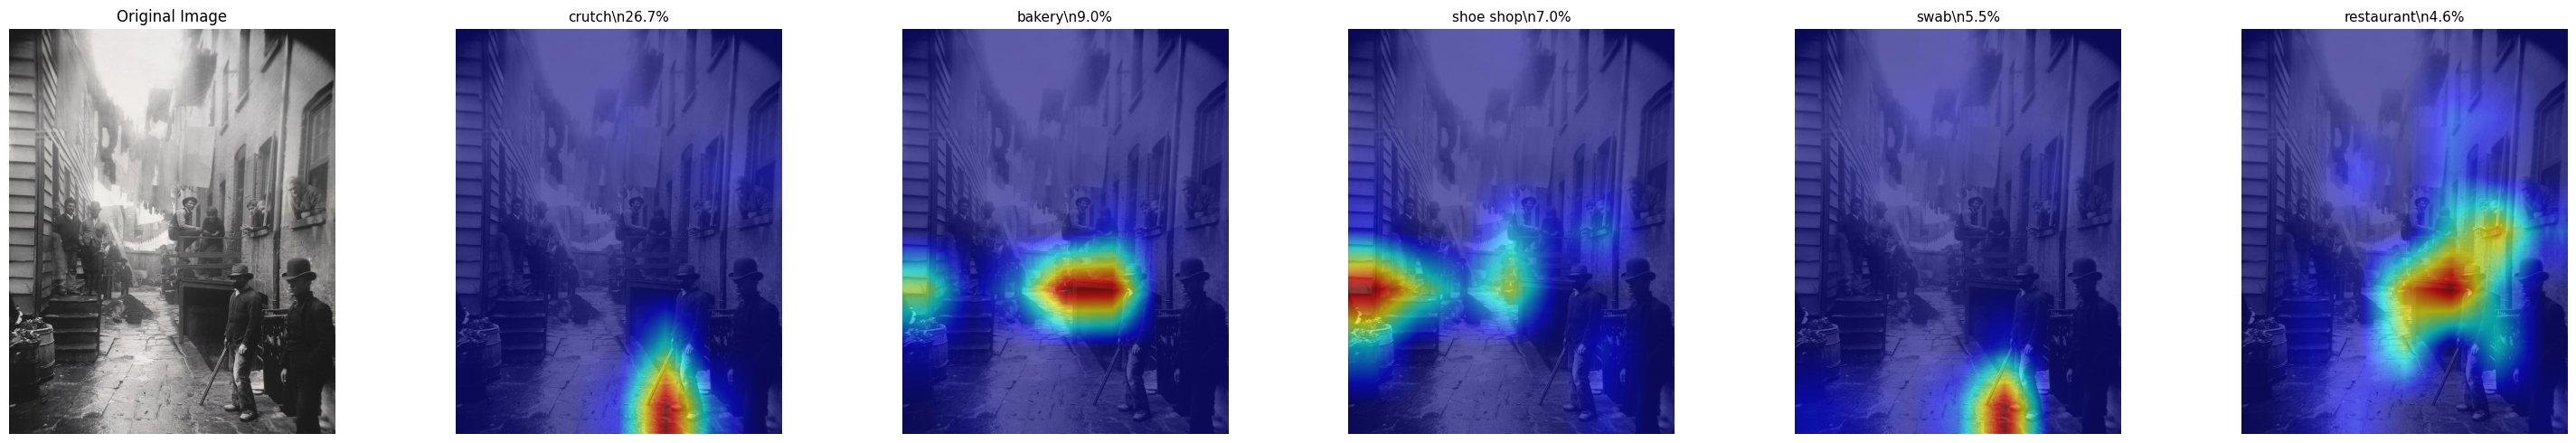

In [ ]:
# Generate Grad-CAM for your image
# Use the same image path from the previous cell
image_path = "/Users/martindokholyan/Desktop/Important/Bandits_Roost,_59_and_a_half_Mulberry_Street.jpg"

fig = generate_gradcam(image_path, model_for_classification, preprocess, imagenet_classes, top_k=3)
plt.show()